# Natural Language Processing Lab

In this lab we will further explore Scikit's and NLTK's capabilities to process text. We will use the 20 Newsgroup dataset, which is provided by Scikit-Learn.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import fetch_20newsgroups

In [5]:
fetch_20newsgroups

AttributeError: 'function' object has no attribute 'keys'

In [6]:

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

data_train = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=('headers', 'footers', 'quotes'))

data_test = fetch_20newsgroups(subset='test', categories=categories,
                               shuffle=True, random_state=42,
                               remove=('headers', 'footers', 'quotes'))

## 1. Data inspection

We have downloaded a few newsgroup categories and removed headers, footers and quotes.

Let's inspect them.

1. What data taype is `data_train`
> sklearn.datasets.base.Bunch
- Is it like a list? Or like a Dictionary? or what?
> Dict
- How many data points does it contain?
- Inspect the first data point, what does it look like?
> A blurb of text

In [7]:
type(data_train)

sklearn.datasets.base.Bunch

In [8]:
data_train.keys()

['description', 'DESCR', 'filenames', 'target_names', 'data', 'target']

In [9]:
len(data_train['data'])

2034

In [10]:
len(data_train['target'])

2034

In [11]:
data_train['data'][0]

u"Hi,\n\nI've noticed that if you only save a model (with all your mapping planes\npositioned carefully) to a .3DS file that when you reload it after restarting\n3DS, they are given a default position and orientation.  But if you save\nto a .PRJ file their positions/orientation are preserved.  Does anyone\nknow why this information is not stored in the .3DS file?  Nothing is\nexplicitly said in the manual about saving texture rules in the .PRJ file. \nI'd like to be able to read the texture rule information, does anyone have \nthe format for the .PRJ file?\n\nIs the .CEL file format available from somewhere?\n\nRych"

## 2. Bag of Words model

Let's train a model using a simple count vectorizer

1. Initialize a standard CountVectorizer and fit the training data
- how big is the feature dictionary
- repeat eliminating english stop words
- is the dictionary smaller?
- transform the training data using the trained vectorizer
- what are the 20 words that are most common in the whole corpus?
- what are the 20 most common words in each of the 4 classes?
- evaluate the performance of a Lotistic Regression on the features extracted by the CountVectorizer
    - you will have to transform the test_set too. Be carefule to use the trained vectorizer, without re-fitting it
- try the following 3 modification:
    - restrict the max_features
    - change max_df and min_df
    - use a fixed vocabulary of size 80 combining the 20 most common words per group found earlier
- for each of the above print a confusion matrix and investigate what gets mixed
> Anwer: not surprisingly if we reduce the feature space we lose accuracy
- print out the number of features for each model

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
cvec = CountVectorizer()
cvec.fit(data_train['data'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
len(cvec.get_feature_names())

26879

In [15]:
cvec = CountVectorizer(stop_words='english')
cvec.fit(data_train['data'])
len(cvec.get_feature_names())

26577

In [16]:
X_train = pd.DataFrame(cvec.transform(data_train['data']).todense(),
                       columns=cvec.get_feature_names())

In [18]:
word_counts = X_train.sum(axis=0)
word_counts.sort_values(ascending = False).head(20)

space       1061
people       793
god          745
don          730
like         682
just         675
does         600
know         592
think        584
time         546
image        534
edu          501
use          468
good         449
data         444
nasa         419
graphics     414
jesus        411
say          409
way          387
dtype: int64

In [19]:
names = data_train['target_names']
names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

In [20]:
y_train = data_train['target']

In [21]:
y_train

array([1, 3, 2, ..., 1, 0, 1])

In [22]:
common_words = []
for i in xrange(4):
    word_count = X_train[y_train==i].sum(axis=0)
    print names[i], "most common words"
    cw = word_count.sort_values(ascending = False).head(20)
#     cw.to_csv('../../../5.2-lesson/assets/datasets/'+names[i]+'_most_common_words.csv')
    print cw
    common_words.extend(cw.index)
    print 

alt.atheism most common words
god         405
people      330
don         262
think       215
just        209
does        207
atheism     199
say         174
believe     163
like        162
atheists    162
religion    156
jesus       155
know        154
argument    148
time        135
said        131
true        131
bible       121
way         120
dtype: int64

comp.graphics most common words
image        484
graphics     410
edu          297
jpeg         267
file         265
use          225
data         219
files        217
images       212
software     212
program      199
ftp          189
available    185
format       178
color        174
like         167
know         165
pub          161
gif          160
does         157
dtype: int64

sci.space most common words
space        989
nasa         374
launch       267
earth        222
like         222
data         216
orbit        201
time         197
shuttle      192
just         189
satellite    187
lunar        182
moon         168
n

In [23]:
X_test = pd.DataFrame(cvec.transform(data_test['data']).todense(),
                      columns=cvec.get_feature_names())

In [24]:
y_test = data_test['target']

In [25]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.745750184774575

In [26]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [27]:
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred)
    if labels is not None:
        cols = ['p_'+c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['p_'+str(i) for i in xrange(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [28]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(CountVectorizer(stop_words='english',
                                      max_features=1000),
                      LogisticRegression(),
                      )
model.fit(data_train['data'], y_train)
y_pred = model.predict(data_test['data'])
print accuracy_score(y_test, y_pred)
docm(y_test, y_pred, names)
print "Number of features:", len(model.steps[0][1].get_feature_names())

0.69623059867
Number of features: 1000


In [42]:
model = make_pipeline(CountVectorizer(stop_words='english',
                                      max_features=1000,
                                      min_df=0.03),
                      LogisticRegression(),
                      )
model.fit(data_train['data'], y_train)
y_pred = model.predict(data_test['data'])
print accuracy_score(y_test, y_pred)
docm(y_test, y_pred, names)
print "Number of features:", len(model.steps[0][1].get_feature_names())

0.650406504065
Number of features: 258


In [43]:
model = make_pipeline(CountVectorizer(stop_words='english',
                                      vocabulary=set(common_words)),
                      LogisticRegression(),
                      )
model.fit(data_train['data'], y_train)
y_pred = model.predict(data_test['data'])
print accuracy_score(y_test, y_pred)
docm(y_test, y_pred, names)
print "Number of features:", len(model.steps[0][1].get_feature_names())

0.589061345159
Number of features: 54


## 3. Hashing and TF-IDF

Let's see if Hashing or TF-IDF improves the accuracy.

1. Initialize a HashingVectorizer and repeat the test with no restriction on the number of features
- does the score improve with respect to the count vectorizer?
    - can you change any of the default parameters to improve it?
- print out the number of features for this model
- Initialize a TF-IDF Vectorizer and repeat the analysis above
- can you improve on your best score above?
    - can you change any of the default parameters to improve it?
- print out the number of features for this model

In [44]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer

In [45]:
model = make_pipeline(HashingVectorizer(stop_words='english',
                                        non_negative=True,
                                        n_features=2**16),
                      LogisticRegression(),
                      )
model.fit(data_train['data'], y_train)
y_pred = model.predict(data_test['data'])
print accuracy_score(y_test, y_pred)
docm(y_test, y_pred, names)
print "Number of features:", 2**16

0.743532889874
Number of features: 65536


In [46]:
model = make_pipeline(TfidfVectorizer(stop_words='english',
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=1000),
                      LogisticRegression(),
                      )
model.fit(data_train['data'], y_train)
y_pred = model.predict(data_test['data'])
print accuracy_score(y_test, y_pred)
docm(y_test, y_pred, names)
print "Number of features:", len(model.steps[0][1].get_feature_names())

0.728011825573
Number of features: 1000


## 4. Classifier comparison

Of all the vectorizers tested above, choose one that has a reasonable performance with a manageable number of features and compare the performance of these models:

- KNN
- Logistic Regression
- Decision Trees
- Support Vector Machine
- Random Forest
- Extra Trees

In order to speed up the calculation it's better to vectorize the data only once and then compare the models.

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [48]:
models = [KNeighborsClassifier(),
          LogisticRegression(),
          DecisionTreeClassifier(),
          SVC(),
          RandomForestClassifier(),
          ExtraTreesClassifier()]

tvec = TfidfVectorizer(stop_words='english',
                       sublinear_tf=True,
                       max_df=0.5,
                       max_features=1000)

tvec.fit(data_train['data'])
X_train = tvec.transform(data_train['data'])
X_test = tvec.transform(data_test['data'])


In [49]:
res = []

for model in models:
    print model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print score
    cm = docm(y_test, y_pred, names)
    print cm
    res.append([model, score])

# pd.DataFrame(res, columns=['model', 'score']).to_csv('../../../5.2-lesson/assets/datasets/20newsgroups/model_comparison.csv')

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
0.277900960828
                    p_alt.atheism  p_comp.graphics  p_sci.space  \
alt.atheism                   149               82           36   
comp.graphics                 172              109           46   
sci.space                     130              107           71   
talk.religion.misc            105               63           36   

                    p_talk.religion.misc  
alt.atheism                           52  
comp.graphics                         62  
sci.space                             86  
talk.religion.misc                    47  
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.728

## Bonus: Other classifiers

Adapt the code from [this example](http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html#example-text-document-classification-20newsgroups-py) to compare across all the classifiers suggested and to display the final plot

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
        max_iter=None, normalize=False, random_state=None, solver='lsqr',
        tol=0.01)
train time: 0.030s
test time:  0.000s
accuracy:   0.708
dimensionality: 1000
density: 1.000000
top 10 keywords per class:
alt.atheism: worse makes satan atheist religion punishment islamic atheists a...
talk.religion.misc: video using images points image hi file 3d computer graphics
comp.graphics: 23 star launch sci engineering flight spacecraft orbit nasa space
sci.space: authority kent context christ sin children order christian christi...
()
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.61      0.53      0.56       319
talk.religion.misc       0.85      0.85      0.85       389
     comp.graphics       0.72      0.82      0.77       394
       

/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:299: UserWarning: In Ridge, only 'sag' solver can currently fit the intercept when X is sparse. Solver has been automatically changed into 'sag'.
  warnings.warn("In Ridge, only 'sag' solver can currently fit the "


train time: 0.003s
test time:  0.114s
accuracy:   0.248
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.24      0.37      0.29       319
talk.religion.misc       0.31      0.28      0.29       389
     comp.graphics       0.31      0.12      0.18       394
         sci.space       0.18      0.25      0.21       251

       avg / total       0.27      0.25      0.24      1353

confusion matrix:
[[117  73  44  85]
 [160 107  38  84]
 [118 103  48 125]
 [102  61  24  64]]
()
Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=Fal

/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/svm/classes.py:197: DeprecationWarning: loss='l2' has been deprecated in favor of loss='squared_hinge' as of 0.16. Backward compatibility for the loss='l2' will be removed in 1.0
  DeprecationWarning)


train time: 0.189s
test time:  0.001s
accuracy:   0.680
dimensionality: 1000
density: 0.521750
top 10 keywords per class:
alt.atheism: worse valid makes islamic nation atheist tells atheism atheists ...
talk.religion.misc: hi card computer file 24 image 3d animation points graphics
comp.graphics: astro satellite flight launch shuttle spacecraft dc rocket orb...
sci.space: fbi holy children taken reply sin elements christ authority order
()
classification report:
                    precision    recall  f1-score   support

       alt.atheism       0.58      0.53      0.55       319
talk.religion.misc       0.77      0.83      0.80       389
     comp.graphics       0.77      0.76      0.76       394
         sci.space       0.51      0.51      0.51       251

       avg / total       0.68      0.68      0.68      1353

confusion matrix:
[[170  27  35  87]
 [ 18 323  35  13]
 [ 26  46 300  22]
 [ 81  22  21 127]]
()
Elastic-Net penalty
____________________________________________________

/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/michael/anaconda/lib/python2.7/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


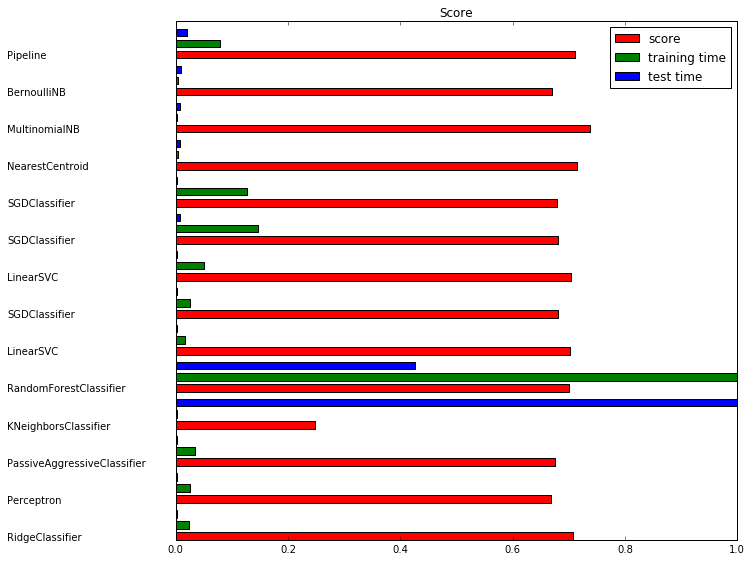

In [50]:
from time import time

from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics

feature_names = np.array(tvec.get_feature_names())

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

###############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(categories):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s"
                      % (category, " ".join(feature_names[top10]))))
        print()


    print("classification report:")
    print(metrics.classification_report(y_test, pred,
                                        target_names=categories))


    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()

## Bonus: NLTK

NLTK is a vast library. Can you find some interesting bits to share with classmates?
Start here: http://www.nltk.org/